In [1]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import nibabel as nib
from nilearn.plotting import plot_glass_brain

/Users/snastase/opt/miniconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# Load in Schaefer atlas
schaefer = nib.load('Schaefer1000_3mm.nii.gz')
atlas, affine = schaefer.get_fdata(), schaefer.affine

In [3]:
# Function for mapping from parcels to voxel image
def parcel_to_voxel(parcel_data, atlas, parcel_ids=np.arange(1000)):
    assert parcel_data.shape == parcel_ids.shape
    voxel_data = np.full(atlas.shape, np.nan)
    for i in parcel_ids:
        voxel_data[atlas == i + 1.] = parcel_data[i]
    return voxel_data

In [4]:
# Function for mapping from ROIs to parcels
def roi_to_parcel(roi_data, roi_ids, n_parcels=1000):
    parcel_data = np.full(n_parcels, np.nan)
    parcel_data[roi_ids] = roi_data
    return parcel_data

In [5]:
# Convencience function for converting to NIfTI
def to_nifti(data, affine=affine):
    return nib.Nifti1Image(data, affine)

/Users/snastase/opt/miniconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


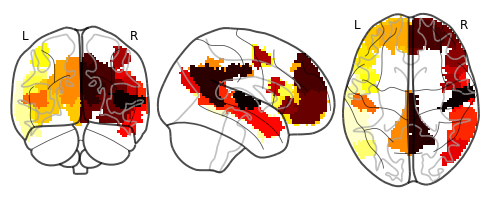

In [6]:
# Load in ROI labels and visualize
roi_labels = np.load('parcel_roi_labels.npy')
roi_names = ['L_PostTemp', 'L_AntTemp', 'L_AngG', 'L_IFG', 'L_MFG',
             'L_IFGorb', 'L_vmPFC', 'L_dmPFC', 'L_PMC', 'L_HG', 'L_V1',
             'R_PostTemp', 'R_AntTemp', 'R_AngG', 'R_IFG', 'R_MFG',
             'R_IFGorb', 'R_vmPFC', 'R_dmPFC', 'R_PMC', 'R_HG', 'R_V1']

# Set V1 to zero and ignore
v1_ids = [i for i, r in enumerate(roi_names) if 'V1' in r]
for v1_id in v1_ids:
    roi_labels[roi_labels == v1_id + 1.] = 0.

roi_ids = np.where(roi_labels != 0)[0]
roi_nii = to_nifti(parcel_to_voxel(roi_labels, atlas))
plot_glass_brain(roi_nii);

In [7]:
# Load in L2-normed transformation weight vectors
weights = np.load('l2norm_layer2brain.npy')
print(weights.shape)

(62, 144, 1000)


In [8]:
# Select only parcels in language ROIs
weights = weights[..., roi_labels != 0]
print(weights.shape)

(62, 144, 194)


In [9]:
# Average weight vectors across subjects
weights = np.mean(weights, axis=0)
print(weights.shape)

(144, 194)


In [10]:
# Z-score across weights per parcel
weights = zscore(weights, axis=0)

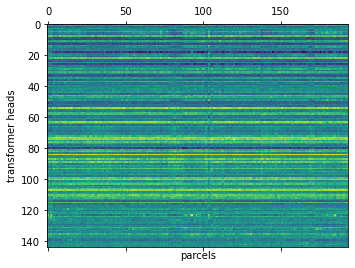

In [11]:
# Visualize transformation magnitude weights
plt.matshow(weights)
plt.xlabel('parcels')
plt.ylabel('transformer heads')
plt.show()

In [12]:
# Run PCA on weight matrix
n_components = 144
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(weights)
vaf = pca.explained_variance_ratio_

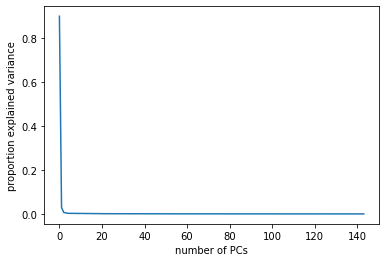

50% variance: 1 components
75% variance: 1 components
90% variance: 2 components
95% variance: 9 components
99% variance: 62 components


In [13]:
# Check proportion explained variance
plt.plot(vaf)
plt.xlabel('number of PCs')
plt.ylabel('proportion explained variance')
plt.show()

vaf_n = {}
for perc in [.5, .75, .9, .95, .99]:
    vaf_n[perc] = np.sum(np.cumsum(vaf) < perc) + 1
    print(f"{perc:.0%} variance: {vaf_n[perc]} components")

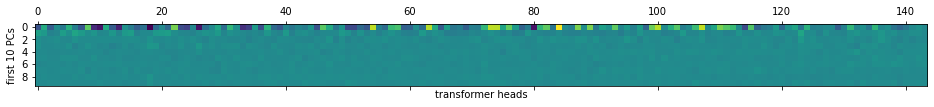

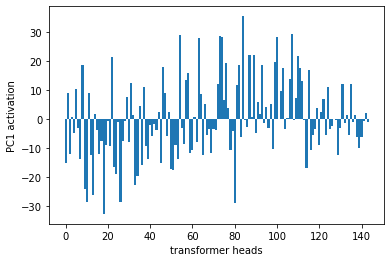

In [14]:
# Visualized PCA-reduced matrix and PCs
num_pcs = 10
plt.matshow(reduced[:, :num_pcs].T)
plt.xlabel('transformer heads')
plt.ylabel(f'first {num_pcs} PCs')
plt.show()

pc = 0
plt.bar(np.arange(len(reduced)), reduced[:, pc], width=1)
plt.xlabel('transformer heads')
plt.ylabel(f'PC{pc + 1} activation')
plt.show()

In [15]:
# Load in head-wise dependency decoding accuracies
decoding_black = np.load(('decoding_results_indiv_bert-base-uncased_black_'
                          'logistic_5_5_train_balanced_score_balanced_nested_'
                          'liblinear.npz'))
decoding_slumlord = np.load(('decoding_results_indiv_bert-base-uncased_'
                             'slumlordreach_logistic_5_5_train_balanced_'
                             'score_balanced_nested_liblinear.npz'))
decoding = np.mean((decoding_black['acc'].reshape(144, 39), 
                    decoding_slumlord['acc'].reshape(144, 39)),
                   axis=0)

decoding = {l: d for l, d in zip(decoding_black['labels'], decoding.T)}
print(list(decoding.keys()))

['nsubj', 'ROOT', 'advmod', 'prep', 'det', 'pobj', 'aux', 'dobj', 'cc', 'ccomp', 'amod', 'compound', 'acomp', 'poss', 'xcomp', 'conj', 'relcl', 'attr', 'mark', 'npadvmod', 'advcl', 'neg', 'prt', 'nummod', 'intj', 'PRON', 'VERB', 'NOUN', 'DET', 'AUX', 'ADP', 'ADV', 'CCONJ', 'ADJ', 'PART', 'PROPN', 'SCONJ', 'NUM', 'INTJ']


In [16]:
# Dependency and part-of-speech labels
dependencies = ['amod', 'poss', 'aux', 'det', 'prt', 'nsubj', 'pobj',
                'prep', 'advmod', 'dobj', 'mark', 'ccomp']
pos = ['PRON', 'VERB', 'NOUN', 'DET', 'AUX', 'ADP', 'ADV', 'CCONJ',
       'ADJ', 'PART', 'PROPN', 'SCONJ', 'NUM', 'INTJ']

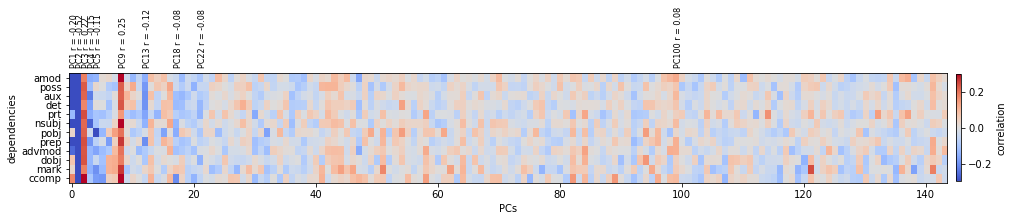

PC2: r = -0.52
PC9: r = 0.25
PC3: r = 0.22
PC1: r = -0.20
PC4: r = -0.15
PC13: r = -0.12
PC5: r = -0.11
PC18: r = -0.08
PC22: r = -0.08
PC100: r = 0.08


In [17]:
# Correlations between PCs and dependency decoding
decs = np.array([decoding[d] for d in dependencies])

corr = 1 - cdist(reduced.T, decs, metric='correlation')

# Get maximumm absolute mean correlation
n_top = 10
max_pcs = np.argpartition(np.abs(np.mean(corr, axis=1)), -n_top)[-n_top::]
max_corrs = np.mean(corr, axis=1)[max_pcs]

fig, ax = plt.subplots(figsize=(16, 10))
im = ax.imshow(corr.T, cmap='coolwarm', vmin=-.3, vmax=.3, aspect=1.5)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('PCs')
ax.set_yticks(np.arange(len(dependencies)))
ax.set_yticklabels(dependencies)
ax.set_ylabel('dependencies')
fig.colorbar(im, label='correlation', fraction=0.006, pad=0.01)
for pc, r in zip(max_pcs, max_corrs):
    ax.annotate(f'PC{pc + 1} r = {r:.2f}', xy=(pc, 0), xytext=(pc -.3, -1), rotation=90, ha='left', va='bottom', fontsize=8) 
plt.show()
sorter = np.argsort(np.abs(max_corrs))[::-1]
for pc, r in zip(max_pcs[sorter], max_corrs[sorter]):
    print(f'PC{pc + 1}: r = {r:.2f}')

In [18]:
# Get PC with the highest value for each dependency
for i, d in enumerate(dependencies):
    max_pc = np.argmax(np.abs(corr[:, i]))
    max_corr = corr[max_pc, i]
    print(f'{d}: PC{max_pc + 1} (r = {max_corr:.2f})')

amod: PC2 (r = -0.51)
poss: PC2 (r = -0.59)
aux: PC2 (r = -0.63)
det: PC1 (r = -0.51)
prt: PC2 (r = -0.54)
nsubj: PC2 (r = -0.51)
pobj: PC2 (r = -0.51)
prep: PC2 (r = -0.53)
advmod: PC2 (r = -0.58)
dobj: PC2 (r = -0.66)
mark: PC2 (r = -0.33)
ccomp: PC9 (r = 0.37)


In [19]:
# Compute loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

/Users/snastase/opt/miniconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


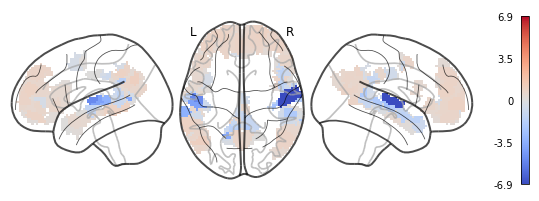

In [20]:
# Get parcel loading for PC1
pc = 0
pc_roi = zscore(loadings[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm',
                 display_mode='lzr');

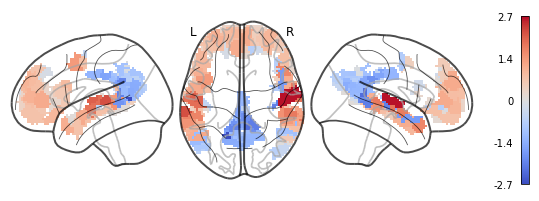

In [21]:
# Get parcel loading for PC2
pc = 1
pc_roi = zscore(loadings[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm',
                 display_mode='lzr');

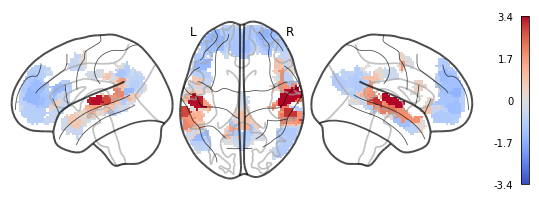

In [22]:
# Get parcel loading for PC3
pc = 2
pc_roi = zscore(loadings[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm',
                 display_mode='lzr');

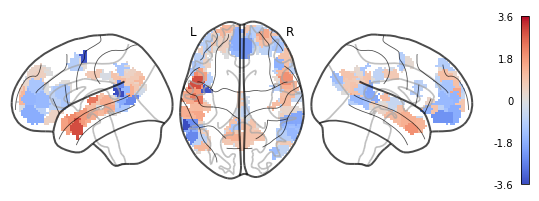

In [23]:
# Get parcel loading for PC5
pc = 4
pc_roi = zscore(loadings[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm',
                 display_mode='lzr');

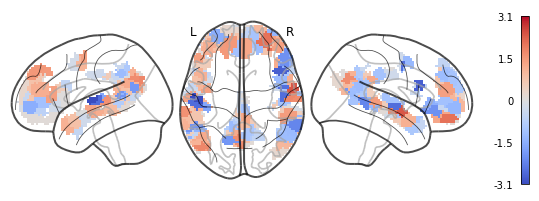

In [24]:
# Get parcel loading for PC9
pc = 8
pc_roi = zscore(loadings[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm',
                 display_mode='lzr');

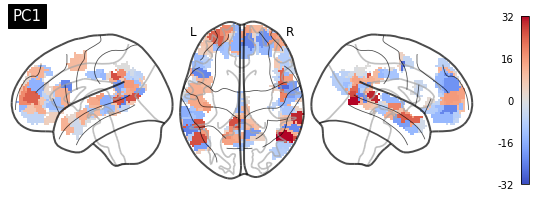

In [25]:
# Project PC1 back onto brain
pc = 0
pc_roi = pca.inverse_transform(-reduced[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm',
                 title=f'PC{pc + 1}', display_mode='lzr');

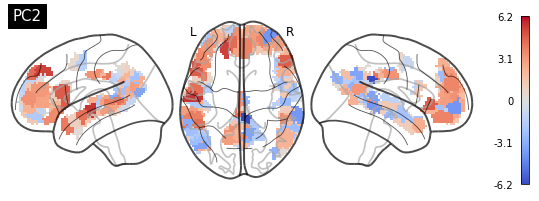

In [26]:
# Project PC2 back onto brain
pc = 1
pc_roi = pca.inverse_transform(reduced[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm',
                 title=f'PC{pc + 1}', display_mode='lzr');

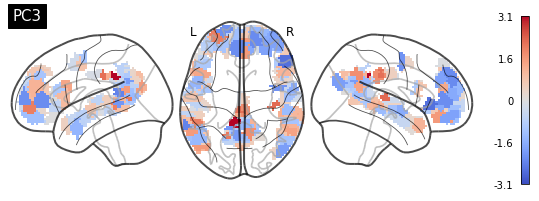

In [27]:
# Project PC3 back onto brain
pc = 2
pc_roi = pca.inverse_transform(-reduced[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm',
                 title=f'PC{pc + 1}', display_mode='lzr');

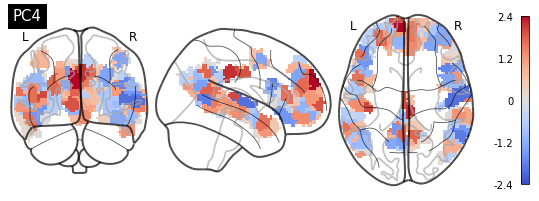

In [28]:
# Project PC4 back onto brain
pc = 3
pc_roi = pca.inverse_transform(reduced[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm', title=f'PC{pc + 1}');

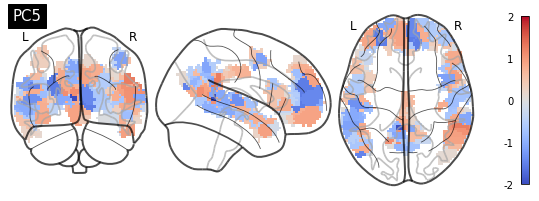

In [29]:
# Project PC5 back onto brain
pc = 4
pc_roi = pca.inverse_transform(reduced[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm', title=f'PC{pc + 1}');

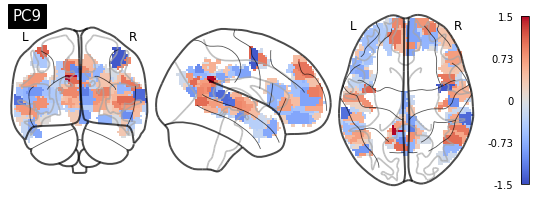

In [30]:
# Project PC9 back onto brain
pc = 8
pc_roi = pca.inverse_transform(-reduced[:, pc])
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='coolwarm', title=f'PC{pc + 1}');

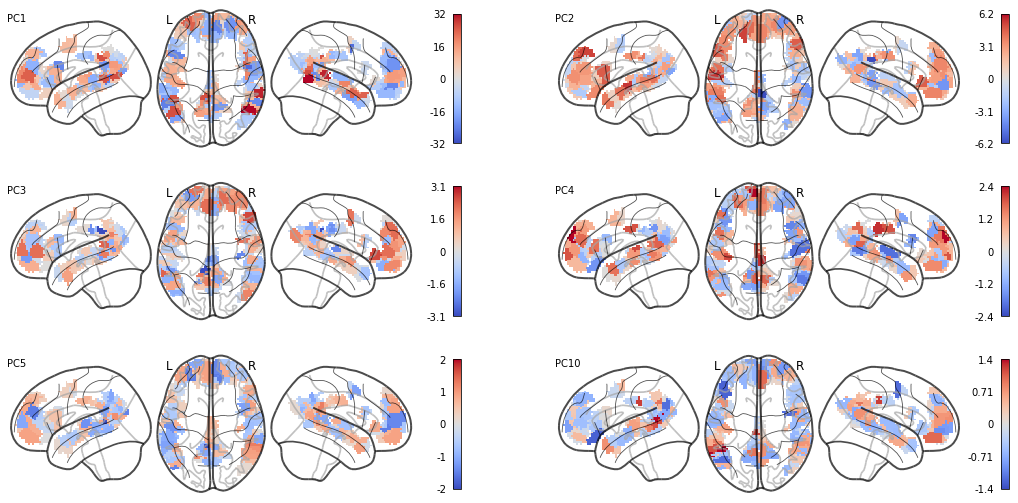

In [31]:
# Plot grid of first few PCs
pcs = [0, 1, 2, 3, 4, 9]

fig, axs = plt.subplots(3, 2, figsize=(18, 9))

for ax, pc in zip(axs.ravel(), pcs):
    pc_roi = pca.inverse_transform(reduced[:, pc])
    if pc == 0:
        pc_roi = -pc_roi
    pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(pc_roi, roi_ids), atlas))
    plot_glass_brain(pc_nii, colorbar=True, plot_abs=False,
                     display_mode='lzr', cmap='coolwarm', axes=ax);
    ax.annotate(f'PC{pc + 1}', xy=(0, .9), xycoords='axes fraction', ha='left')
plt.savefig('transformation_pca_proj_supp.png', bbox_inches='tight',
            transparent=True, dpi=300)

In [32]:
# Save coolwarm colorbar for plots
a = np.arange(1, 20)[:, np.newaxis]
fig, ax = plt.subplots()
ax.imshow(a, cmap='coolwarm', interpolation='bilinear')
plt.box(False)
plt.yticks([])
plt.xticks([]);
plt.savefig('coolwarm_colorbar.svg', bbox_inches='tight',
            transparent=True, dpi=300)

In [33]:
# Functions for creating discrete colorbar for layers
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors


def colorbar_index(ncolors, cmap, cax=None, ax=None, label=None):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, cax=cax, ax=ax)
    colorbar.set_label(label, rotation=270, va='center')
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(np.arange(ncolors) + 1)

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in range(N+1) ]
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

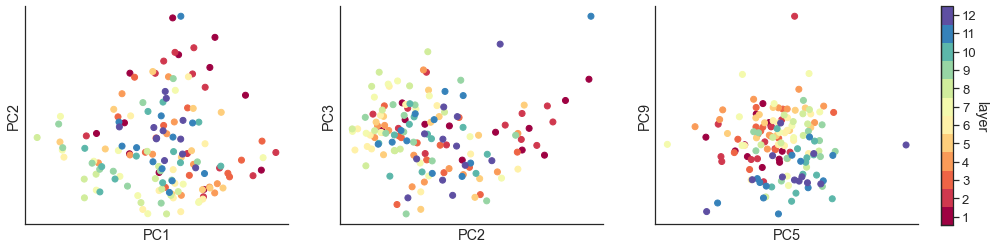

In [34]:
# Create layer index for all heads and plot on PCs
layer = np.repeat(np.arange(12) + 1, 12, axis=0)
cmap = colors.ListedColormap(plt.cm.Spectral(np.linspace(0, 1, 12)))

xys = [(0, 1), (1, 2), (4, 8)]

sns.set(style='white', font_scale=1.2)
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for ax, (x, y) in zip(axs, xys):
    if x == 0:
        s = ax.scatter(-reduced[:, x], reduced[:, y], c=layer, cmap=cmap)
    else:
        s = ax.scatter(reduced[:, x], reduced[:, y], c=layer, cmap=cmap)
    ax.set(xlabel=f'PC{x + 1}',
           ylabel=f'PC{y + 1}',
           xticks=[], yticks=[])
cax = fig.add_axes([.92, 0.12, 0.01, 0.76])
colorbar_index(ncolors=12, cmap=cmap, cax=cax, label='layer')
sns.despine()

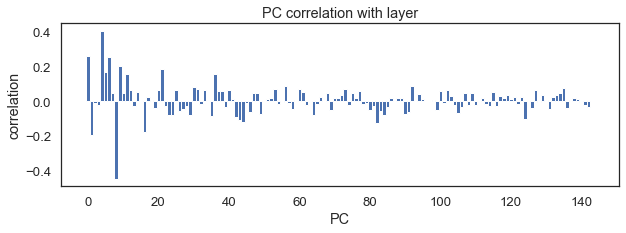

PC9: r = -0.45
PC5: r = 0.40
PC1: r = 0.26
PC7: r = 0.25
PC10: r = 0.20


In [35]:
# Correlations between PCs and layer
decs = np.array([decoding[d] for d in dependencies])

n_top = 5
corr = 1 - cdist(reduced.T, layer[np.newaxis, :], metric='correlation')[:, 0]
max_pcs = np.argpartition(np.abs(corr), -n_top)[-n_top::]
max_corrs = corr[max_pcs]

fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(np.arange(len(reduced)), corr, width=1)
plt.xlabel('PC')
plt.ylabel(f'correlation')
plt.title('PC correlation with layer')
plt.show()
sorter = np.argsort(np.abs(max_corrs))[::-1]
for pc, r in zip(max_pcs[sorter], max_corrs[sorter]):
    print(f'PC{pc + 1}: r = {r:.2f}')

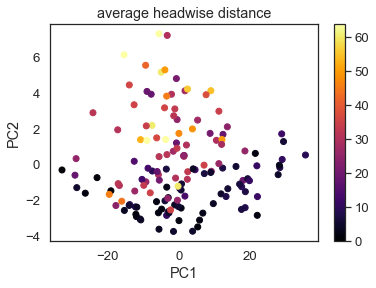

In [36]:
# Plot headwise average distance for black story
head_distance_fn = 'combined_black_slumlord_bert-base-uncased_headwise-distance_T-128_D-bck.npy'
head_distance = np.load(head_distance_fn).reshape(144)

x_dim, y_dim = 0, 1
plt.scatter(reduced[:, x_dim], reduced[:, y_dim],
            c=head_distance, cmap='inferno', vmin=0, vmax=64)
plt.colorbar()
plt.title(f'average headwise distance')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

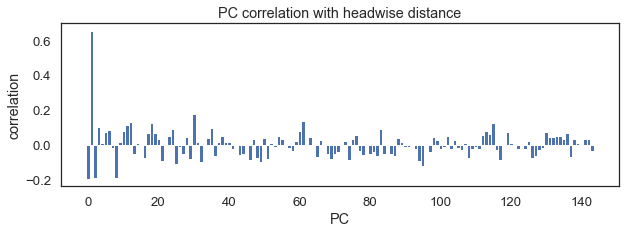

PC2: r = 0.65
PC1: r = -0.20
PC3: r = -0.19
PC9: r = -0.19
PC31: r = 0.17


In [37]:
# Correlations between PCs and look-back distance
n_top = 5
corr = 1 - cdist(reduced.T, head_distance[np.newaxis, :],
                 metric='correlation')[:, 0]
max_pcs = np.argpartition(np.abs(corr), -n_top)[-n_top::]
max_corrs = corr[max_pcs]

fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(np.arange(len(reduced)), corr, width=1)
plt.xlabel('PC')
plt.ylabel(f'correlation')
plt.title('PC correlation with headwise distance')
plt.show()
sorter = np.argsort(np.abs(max_corrs))[::-1]
for pc, r in zip(max_pcs[sorter], max_corrs[sorter]):
    print(f'PC{pc + 1}: r = {r:.2f}')

In [38]:
# Get head with maximum decoding accuracy for each dependency
max_head = {l: np.argmax(d) for l, d in decoding.items()}

label_head = np.full(144, np.nan)
for d in dependencies:
    label_head[max_head[d]] = 1
    
# Get labels for heads with maximum decoding
head_labels = {}
for h in np.unique([max_head[d] for d in dependencies]):
    head_labels[h] = []
    for d in dependencies:
        if max_head[d] == h:
            head_labels[h].append(d)
head_labels = {h: '\n'.join(head_labels[h]) for h in head_labels}

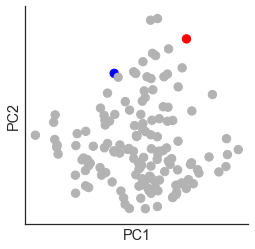

In [39]:
# Create simple PCA plot without any colors
x_dim, y_dim = 0, 1
sns.set(style='white', font_scale=1.2)
fig, ax = plt.subplots(figsize=(4, 4))

c = ['red', 'blue'] + ['.7'] * 142
#c = ['.7'] * 144
s = ax.scatter(-reduced[:, x_dim], reduced[:, y_dim], c=c, s=70)
ax.set(xlabel=f'PC{x_dim + 1}',
       ylabel=f'PC{y_dim + 1}',
       xticks=[], yticks=[],
       ylim=(-4.6, 8))
sns.despine()
#plt.savefig('blank_pca.svg', bbox_inches='tight',
#            transparent=True, dpi=300)

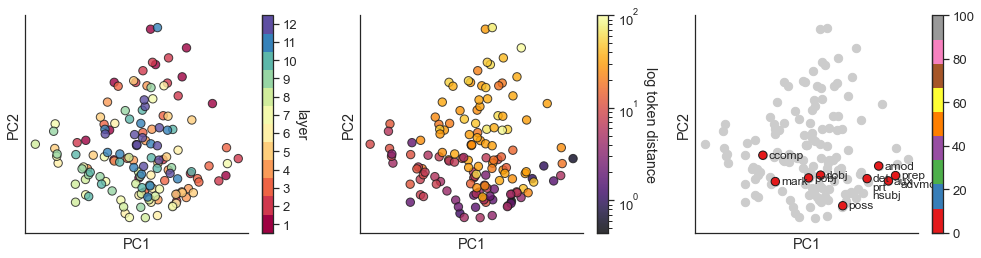

In [40]:
# Create layer index for all heads and plot on PCs
from matplotlib.colors import LogNorm

layer = np.repeat(np.arange(12) + 1, 12, axis=0)
layer_cmap = colors.ListedColormap(plt.cm.Spectral(np.linspace(0, 1, 12)))

x_dim, y_dim = 0, 1
sns.set(style='white', font_scale=1.2)
fig, axs = plt.subplots(1, 3, figsize=(17, 4), sharex=True, sharey=True)

s0 = axs[0].scatter(-reduced[:, x_dim], reduced[:, y_dim], c=layer, cmap=layer_cmap,
                    edgecolors='k', linewidth=1, s=70, alpha=.8)
axs[0].set(xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])
colorbar_index(ncolors=12, cmap=layer_cmap, ax=axs[0], label='layer')

x_dim, y_dim = 0, 1
s1 = axs[1].scatter(-reduced[:, x_dim], reduced[:, y_dim], s=70,
                    c=head_distance, cmap='inferno', #vmin=0, vmax=64,
                    edgecolors='k', linewidth=1, alpha=.8,
                    norm=LogNorm(vmax=100))
cb = fig.colorbar(s1, ax=axs[1])
cb.set_label('log token distance', rotation=270, va='bottom')
axs[1].set(xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])

axs[2].scatter(-reduced[:, x_dim], reduced[:, y_dim], c='.8', s=70)
s2 = axs[2].scatter(-reduced[:, x_dim], reduced[:, y_dim],
                    c=label_head, cmap='Set1', vmin=0, vmax=100,
                    edgecolors='k', linewidth=1, s=70)
for h, l in head_labels.items():
    axs[2].annotate(l, xy=(-reduced[h, x_dim], reduced[h, y_dim]), fontsize=12,
                    ha='left', va='top', xytext=(5.5, 5.1), textcoords='offset points',
                    linespacing=.8)
axs[2].set(xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[],
           ylim=(-4.6, 8))
cb = fig.colorbar(s2, ax=axs[2])

sns.despine()
plt.savefig('transformation_pca_top_log.svg', bbox_inches='tight',
            transparent=True, dpi=300)

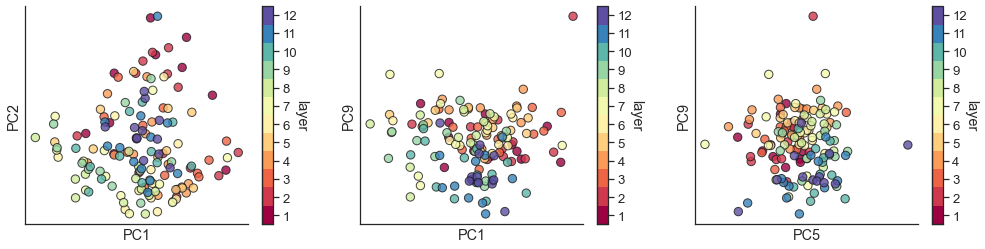

In [41]:
# Create layer index for all heads and plot on PCs
from matplotlib.colors import LogNorm

layer = np.repeat(np.arange(12) + 1, 12, axis=0)
layer_cmap = colors.ListedColormap(plt.cm.Spectral(np.linspace(0, 1, 12)))

x_dim, y_dim = 0, 1
sns.set(style='white', font_scale=1.2)
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

s0 = axs[0].scatter(-reduced[:, x_dim], reduced[:, y_dim], c=layer, cmap=layer_cmap,
                    edgecolors='k', linewidth=1, s=70, alpha=.8)
axs[0].set(xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])
colorbar_index(ncolors=12, cmap=layer_cmap, ax=axs[0], label='layer')

x_dim, y_dim = 0, 8
s1 = axs[1].scatter(-reduced[:, x_dim], reduced[:, y_dim], c=layer, cmap=layer_cmap,
                    edgecolors='k', linewidth=1, s=70, alpha=.8)
axs[1].set(xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])
colorbar_index(ncolors=12, cmap=layer_cmap, ax=axs[1], label='layer')

x_dim, y_dim = 4, 8
s2 = axs[2].scatter(reduced[:, x_dim], reduced[:, y_dim], c=layer, cmap=layer_cmap,
                    edgecolors='k', linewidth=1, s=70, alpha=.8)
axs[2].set(xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])
colorbar_index(ncolors=12, cmap=layer_cmap, ax=axs[2], label='layer')

sns.despine()
plt.savefig('transformation_pca_layer_supp.png', bbox_inches='tight',
            transparent=True, dpi=300)

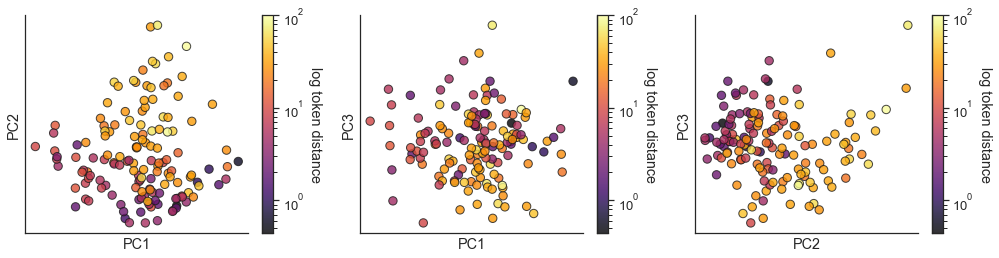

In [42]:
# Create layer index for all heads and plot on PCs
from matplotlib.colors import LogNorm

sns.set(style='white', font_scale=1.2)
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

x_dim, y_dim = 0, 1
s1 = axs[0].scatter(-reduced[:, x_dim], reduced[:, y_dim], s=70,
                    c=head_distance, cmap='inferno', #vmin=0, vmax=64,
                    edgecolors='k', linewidth=1, alpha=.8,
                    norm=LogNorm(vmax=100))
cb = fig.colorbar(s1, ax=axs[0])
cb.set_label('log token distance', rotation=270, va='bottom')
axs[0].set(xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])

x_dim, y_dim = 0, 2
s1 = axs[1].scatter(-reduced[:, x_dim], reduced[:, y_dim], s=70,
                    c=head_distance, cmap='inferno', #vmin=0, vmax=64,
                    edgecolors='k', linewidth=1, alpha=.8,
                    norm=LogNorm(vmax=100))
cb = fig.colorbar(s1, ax=axs[1])
cb.set_label('log token distance', rotation=270, va='bottom')
axs[1].set(xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])

x_dim, y_dim = 1, 2
s1 = axs[2].scatter(reduced[:, x_dim], reduced[:, y_dim], s=70,
                    c=head_distance, cmap='inferno', #vmin=0, vmax=64,
                    edgecolors='k', linewidth=1, alpha=.8,
                    norm=LogNorm(vmax=100))
cb = fig.colorbar(s1, ax=axs[2])
cb.set_label('log token distance', rotation=270, va='bottom')
axs[2].set(xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])

sns.despine()
plt.savefig('transformation_pca_dist_supp.png', bbox_inches='tight',
            transparent=True, dpi=300)

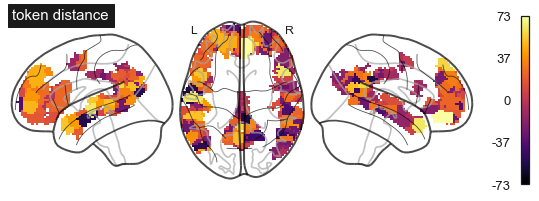

In [43]:
# Project look-back distance onto brain
inv_dist = pca.inverse_transform(head_distance)
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(inv_dist, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='inferno',
                 title=f'token distance', display_mode='lzr');

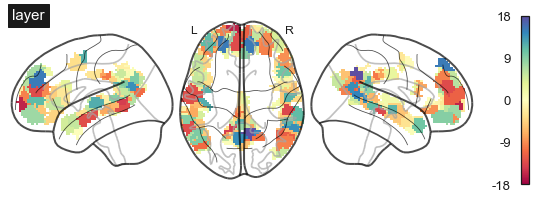

In [44]:
# Project layer onto brain
inv_layer = pca.inverse_transform(layer)
pc_nii = to_nifti(parcel_to_voxel(roi_to_parcel(inv_layer, roi_ids), atlas))
plot_glass_brain(pc_nii, colorbar=True, plot_abs=False, cmap='Spectral',
                 title=f'layer', display_mode='lzr');

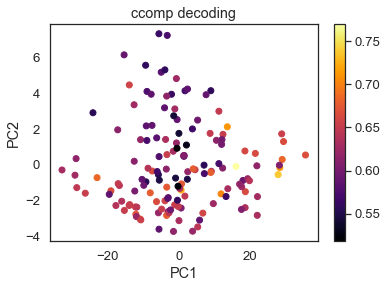

In [45]:
# Plot individual dependency decoding accuracies on PCs
dependency = 'ccomp'

x_dim, y_dim = 0, 1
plt.scatter(reduced[:, x_dim], reduced[:, y_dim],
            c=decoding[dependency], cmap='inferno')
plt.colorbar()
plt.title(f'{dependency} decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

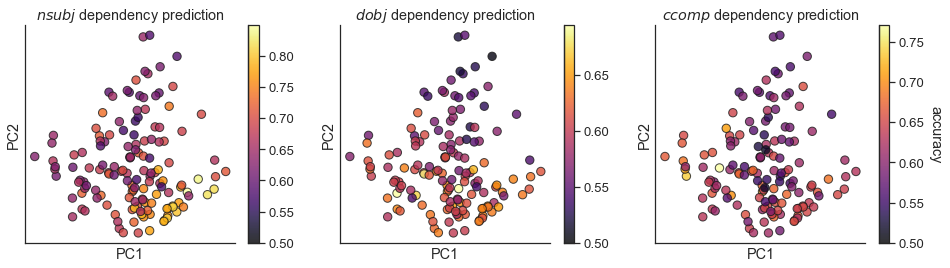

In [46]:
# Plot dependency decoding for multiple dependencies
from matplotlib.ticker import FormatStrFormatter

fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

ds = ['nsubj', 'dobj', 'ccomp']
x_dim, y_dim = 0, 1

sns.set(style='white', font_scale=1.2)
for ax, d in zip(axs, ds):
    s = ax.scatter(-reduced[:, x_dim], reduced[:, y_dim],
                   c=decoding[d], cmap='inferno', vmin=.5,
                   s=70, edgecolors='k', linewidth=1, alpha=.8)
    ax.set(title=f'$\it{d}$ dependency prediction',
           xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])
    cb = fig.colorbar(s, ax=ax, ticks=np.arange(.5, 1., .05))
cb.set_label('accuracy', rotation=270, va='bottom')
sns.despine()
plt.savefig('transformation_pca_decoding.svg', bbox_inches='tight',
            transparent=True, dpi=300)

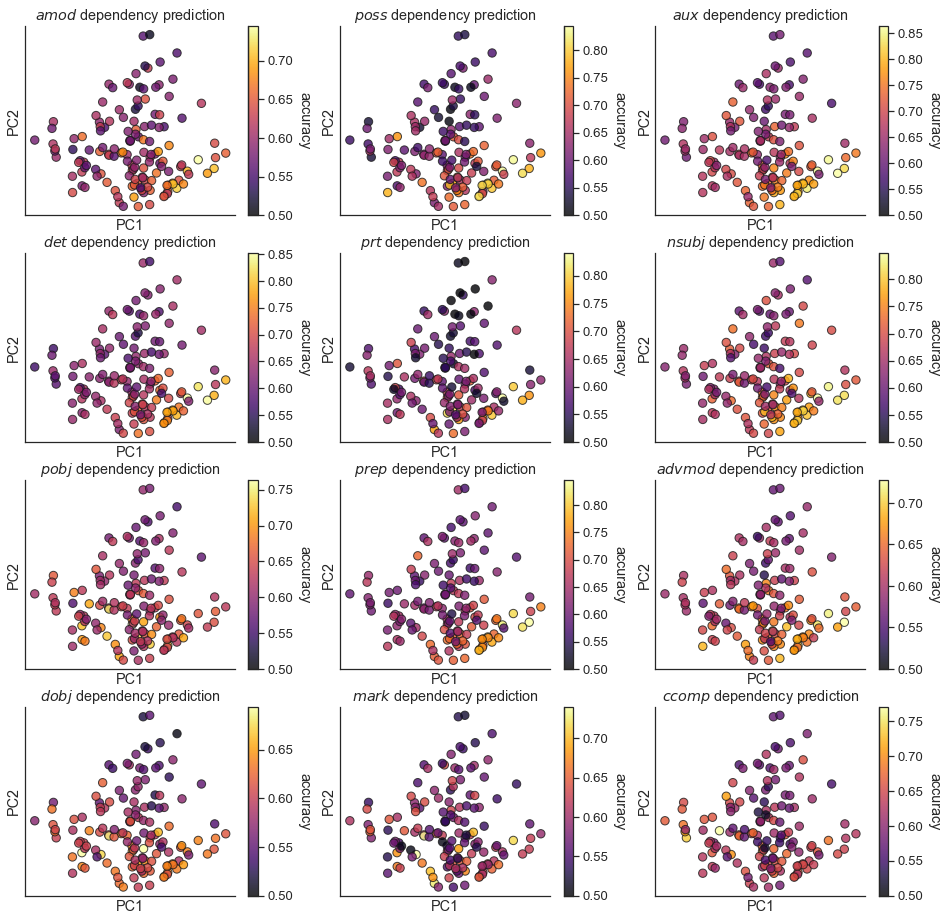

In [47]:
# Plot dependency decoding for multiple dependencies
from matplotlib.ticker import FormatStrFormatter

fig, axs = plt.subplots(4, 3, figsize=(16, 16), sharex=True, sharey=True)

ds = ['amod', 'poss', 'aux',
      'det', 'prt', 'nsubj',
      'pobj', 'prep', 'advmod',
      'dobj', 'mark', 'ccomp']
x_dim, y_dim = 0, 1

sns.set(style='white', font_scale=1.2)
for ax, d in zip(axs.ravel(), ds):
    s = ax.scatter(-reduced[:, x_dim], reduced[:, y_dim],
                   c=decoding[d], cmap='inferno', vmin=.5,
                   s=70, edgecolors='k', linewidth=1, alpha=.8)
    ax.set(title=f'$\it{d}$ dependency prediction',
           xlabel=f'PC{x_dim + 1}',
           ylabel=f'PC{y_dim + 1}',
           xticks=[], yticks=[])
    cb = fig.colorbar(s, ax=ax, ticks=np.arange(.5, 1., .05))
    cb.set_label('accuracy', rotation=270, va='bottom')
sns.despine()
plt.savefig('transformation_pca_decoding_supp.png', bbox_inches='tight',
            transparent=True, dpi=300)

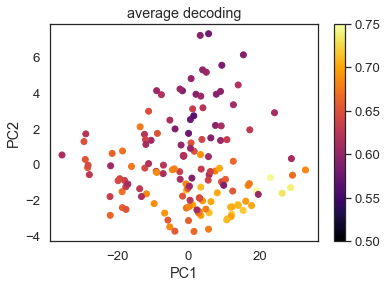

In [48]:
# Plot average decoding accuracy across dependencies/PoS
decoding_avg = np.mean([decoding[d] for d in decoding], axis=0)

x_dim, y_dim = 0, 1
plt.scatter(-reduced[:, x_dim], reduced[:, y_dim],
            c=decoding_avg, cmap='inferno', vmin=.5, vmax=.75)
plt.colorbar()
plt.title('average decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

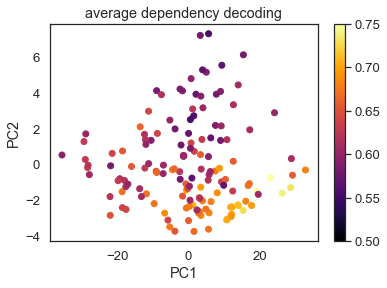

In [49]:
# Plot average decoding accuracy across dependencies only
decoding_avg = np.mean([decoding[d] for d in decoding
                        if d in dependencies], axis=0)

x_dim, y_dim = 0, 1
plt.scatter(-reduced[:, x_dim], reduced[:, y_dim],
            c=decoding_avg, cmap='inferno', vmin=.5, vmax=.75)
plt.colorbar()
plt.title('average dependency decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

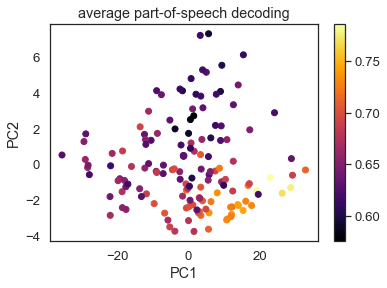

In [50]:
# Plot average decoding accuracy across PoS only
decoding_avg = np.mean([decoding[d] for d in decoding
                        if d in pos], axis=0)

x_dim, y_dim = 0, 1
plt.scatter(-reduced[:, x_dim], reduced[:, y_dim],
            c=decoding_avg, cmap='inferno')
plt.colorbar()
plt.title('average part-of-speech decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

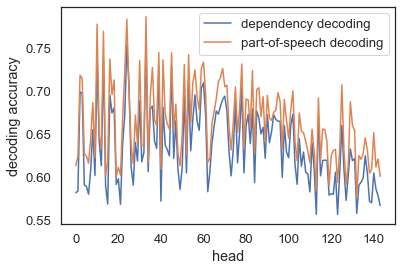

In [51]:
# Check similarity of average dependency/PoS decoding
mean_dep = np.mean([decoding[d] for d in decoding if d in dependencies],
                   axis = 0)
mean_pos = np.mean([decoding[d] for d in decoding if d in pos], axis=0)
plt.plot(np.stack((mean_dep, mean_pos), axis=0).T)
plt.xlabel('head')
plt.ylabel('decoding accuracy')
plt.legend(labels=['dependency decoding', 'part-of-speech decoding'])
plt.show()

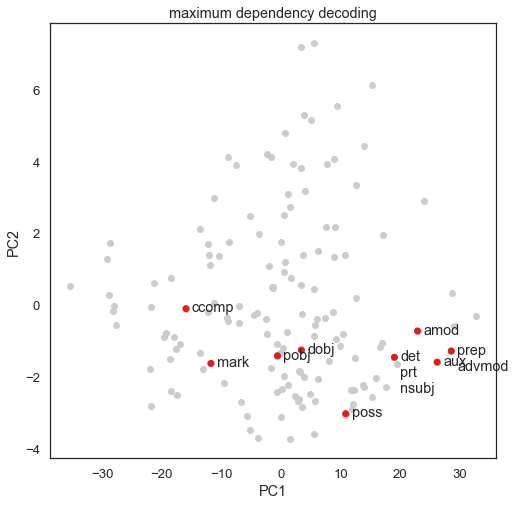

In [52]:
# Get head with maximum decoding accuracy for each dependency
max_head = {l: np.argmax(d) for l, d in decoding.items()}

label_head = np.full(144, np.nan)
for d in dependencies:
    label_head[max_head[d]] = 1
    
# Get labels for heads with maximum decoding
head_labels = {}
for h in np.unique([max_head[d] for d in dependencies]):
    head_labels[h] = []
    for d in dependencies:
        if max_head[d] == h:
            head_labels[h].append(d)
head_labels = {h: '\n'.join(head_labels[h]) for h in head_labels}

x_dim, y_dim = 0, 1
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(-reduced[:, x_dim], reduced[:, y_dim], c='.8')
ax.scatter(-reduced[:, x_dim], reduced[:, y_dim],
            c=label_head, cmap='Set1')
for h, l in head_labels.items():
    ax.annotate(l, xy=(-reduced[h, x_dim], reduced[h, y_dim]),
                ha='left', va='top', xytext=(6, 8), textcoords='offset points')
plt.title('maximum dependency decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

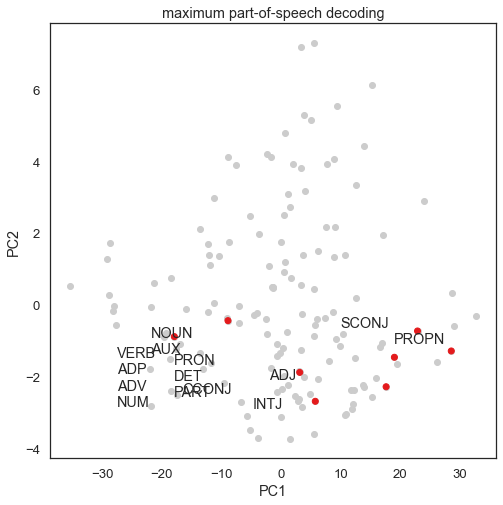

In [53]:
# Get head with maximum decoding accuracy for each part of speech
max_head = {l: np.argmax(d) for l, d in decoding.items()}

label_head = np.full(144, np.nan)
for p in pos:
    label_head[max_head[p]] = 1
    
# Get labels for heads with maximum decoding
head_labels = {}
for h in np.unique([max_head[p] for p in pos]):
    head_labels[h] = []
    for p in pos:
        if max_head[p] == h:
            head_labels[h].append(p)
head_labels = {h: '\n'.join(head_labels[h]) for h in head_labels}

x_dim, y_dim = 0, 1
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(-reduced[:, x_dim], reduced[:, y_dim], c='.8')
ax.scatter(-reduced[:, x_dim], reduced[:, y_dim],
            c=label_head, cmap='Set1')
for h, l in head_labels.items():
    ax.annotate(l, xy=(reduced[h, x_dim], reduced[h, y_dim]),
                ha='left', va='top', xytext=(6, 4.5), textcoords='offset points')
plt.title('maximum part-of-speech decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

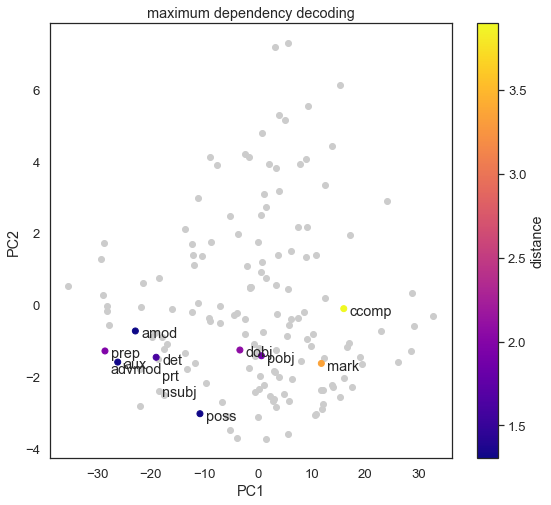

In [54]:
# Get look-back distances for different dependencies
distance = {'prep': 1.8934207393803353,
            'pobj': 1.857141391129446,
            'det': 1.412762600846713,
            'nsubj': 1.6109342012667136,
            'amod': 1.3039366769403193,
            'dobj': 2.068421052631579,
            'advmod': 1.971769271014998,
            'aux': 1.323232323232323,
            'poss': 1.3166902404526166,
            'ccomp': 3.8972332015810274,
            'mark': 3.342400946185689,
            'prt': 1.5675213675213677}

# Get head with maximum decoding accuracy for each dependency
max_head = {l: np.argmax(d) for l, d in decoding.items()}

label_head = np.full(144, np.nan)
for d in dependencies:
    #label_head[max_head[d]] = distance[d]
    label_head[max_head[d]] = distance[d]
    
# Get labels for heads with maximum decoding
head_labels = {}
head_dists = {}
for h in np.unique([max_head[d] for d in dependencies]):
    head_labels[h], head_dists[h] = [], []
    for d in dependencies:
        if max_head[d] == h:
            head_labels[h].append(d)
            head_dists[h].append(distance[d])
head_labels = {h: '\n'.join(head_labels[h]) for h in head_labels}
head_dists = {h: np.mean(head_dists[h]) for h in head_dists}

x_dim, y_dim = 0, 1
fig, ax = plt.subplots(figsize=(9, 8))
ax.scatter(-reduced[:, x_dim], reduced[:, y_dim], c='.8')
s = ax.scatter(reduced[:, x_dim], reduced[:, y_dim],
               c=label_head, cmap='plasma')
plt.colorbar(s, label='distance')
for h, l in head_labels.items():
    ax.annotate(l, xy=(reduced[h, x_dim], reduced[h, y_dim]),
                ha='left', va='top', xytext=(6, 4.5), textcoords='offset points')
plt.title('maximum dependency decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

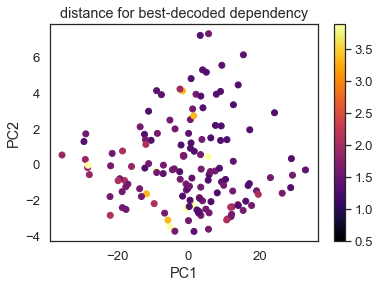

In [55]:
# Compute distance for best-decoded dependency for each head
max_per_head = np.argmax([decoding[d] for d in decoding if d in dependencies], axis=0)
dist_per_head = [distance[dependencies[i]] for i in max_per_head]


x_dim, y_dim = 0, 1
plt.scatter(-reduced[:, x_dim], reduced[:, y_dim],
            c=dist_per_head, cmap='inferno',
            vmin=.5,
            vmax=np.amax(list(distance.values())))
plt.colorbar()
plt.title('distance for best-decoded dependency')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

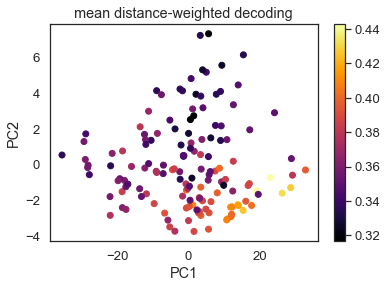

In [56]:
# Computed weighted average of accuracy and distance for all heads
weighted = np.mean(np.array([decoding[d] for d in decoding
                             if d in dependencies]) /
                   np.array([distance[d] for d in decoding
                             if d in dependencies])[:, np.newaxis],
                   axis=0)

x_dim, y_dim = 0, 1
plt.scatter(-reduced[:, x_dim], reduced[:, y_dim],
            c=weighted, cmap='inferno')
plt.colorbar()
plt.title('mean distance-weighted decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

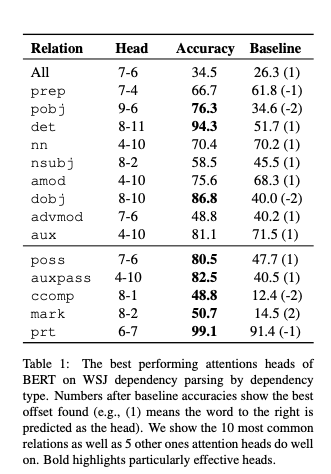

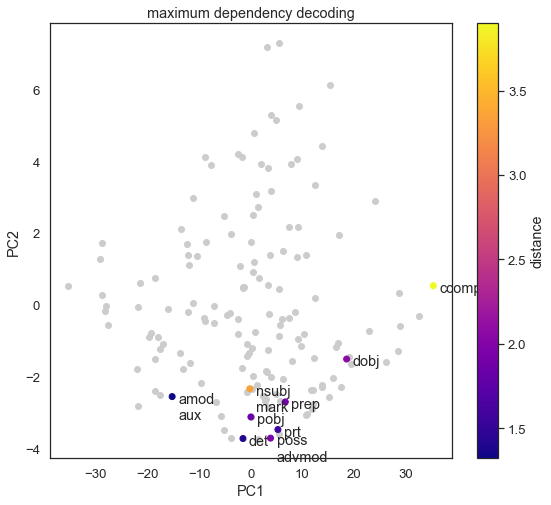

In [57]:
# Plot labeled heads from Clark et al.
clark_head = {'prep': (7, 4), 'pobj': (9, 6), 'det': (8, 11), 'nn': (4, 10),
              'nsubj': (8, 2), 'amod': (4, 10), 'dobj': (8, 10),
              'advmod': (7, 6), 'aux': (4, 10), 'poss': (7,6),
              'auxpass': (4, 10), 'ccomp': (8, 1), 'mark': (8, 2),
              'prt': (6, 7)}
clark_head = {c: (i - 1) * 12 + j - 1 for c, (i, j) in clark_head.items()}

label_head = np.full(144, np.nan)
for d in dependencies:
    label_head[clark_head[d]] = distance[d]
    
# Get labels for heads with maximum decoding
head_labels = {}
for h in np.unique([clark_head[d] for d in dependencies]):
    head_labels[h] = []
    for d in dependencies:
        if clark_head[d] == h:
            head_labels[h].append(d)
head_labels = {h: '\n'.join(head_labels[h]) for h in head_labels}

x_dim, y_dim = 0, 1
fig, ax = plt.subplots(figsize=(9, 8))
ax.scatter(-reduced[:, x_dim], reduced[:, y_dim], c='.8')
s = ax.scatter(reduced[:, x_dim], reduced[:, y_dim],
            c=label_head, cmap='plasma')
plt.colorbar(s, label='distance')
for h, l in head_labels.items():
    ax.annotate(l, xy=(reduced[h, x_dim], reduced[h, y_dim]),
                ha='left', va='top', xytext=(6, 4.5), textcoords='offset points')
plt.title('maximum dependency decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

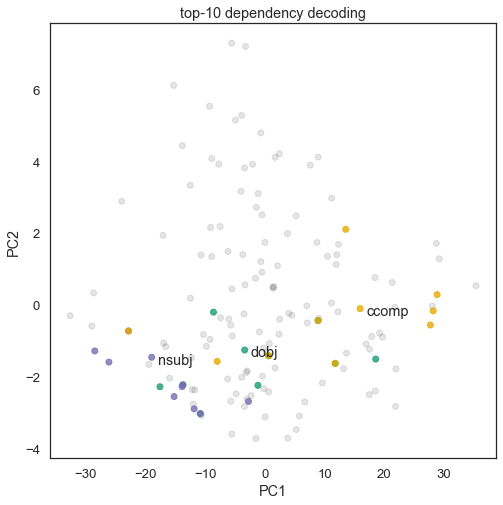

In [58]:
# Highlight top N heads with highest decoding accuracy for dependencies
n = 10
deps = ['dobj', 'nsubj', 'ccomp']

# Get head with maximum decoding accuracy for each dependency
top_heads = {l: np.argpartition(d, -n)[-n:] for l, d in decoding.items()}
max_head = {l: np.argmax(d) for l, d in decoding.items()}

label_head = {}
for i, d in enumerate(deps):
    lh = np.full(144, np.nan)
    lh[top_heads[d]] = i
    label_head[d] = lh

other_head = np.full(144, 1.)
for d in deps:
    for h in top_heads[d]:
        other_head[h] = np.nan
    
# Get labels for heads with maximum decoding
head_labels = {}
for h in np.unique([max_head[d] for d in deps]):
    head_labels[h] = []
    for d in deps:
        if max_head[d] == h:
            head_labels[h].append(d)
head_labels = {h: '\n'.join(head_labels[h]) for h in head_labels}

x_dim, y_dim = 0, 1
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(reduced[:, x_dim], reduced[:, y_dim], c=other_head,
           cmap='binary_r', alpha=.1)
for i, d in enumerate(deps):
    ax.scatter(reduced[:, x_dim], reduced[:, y_dim],
               c=label_head[d], vmin=0, vmax=len(deps),
               cmap='Dark2', alpha=.8)
for h, l in head_labels.items():
    ax.annotate(l, xy=(reduced[h, x_dim], reduced[h, y_dim]),
                ha='left', va='top', xytext=(6, 4.5), textcoords='offset points')
plt.title(f'top-{n} dependency decoding')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()

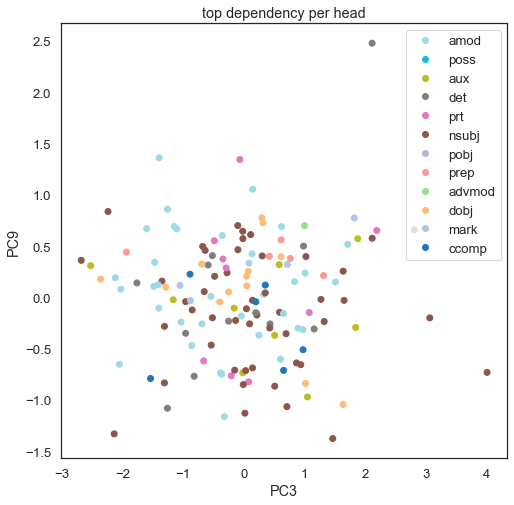

In [59]:
# Find best dependency for each head
max_dep = np.argmax([decoding[d] for d in decoding if d in dependencies], axis=0) + 1

x_dim, y_dim = 2, 8
fig, ax = plt.subplots(figsize=(8, 8))
s = ax.scatter(reduced[:, x_dim], reduced[:, y_dim],
               c=max_dep, cmap='tab20_r')
ax.legend(s.legend_elements()[0], dependencies)
plt.title(f'top dependency per head')
plt.xlabel(f'PC{x_dim + 1}')
plt.ylabel(f'PC{y_dim + 1}')
plt.show()